# Aggressive Language Identification Using Word Embeddings and Sentiment Features

This notebook presents the code of my participation in the <a href="https://sites.google.com/view/trac1/shared-task" target="_blank">First Shared Task on Aggression Identification</a>. More details about the approach can be found in:

Constantin Orǎsan (2018) Aggressive Language Identification Using Word Embeddings and Sentiment Features. In *Proceedings of the First Workshop on Trolling, Aggression and Cyberbullying (TRAC-2018)*, p. 113 - 119, Santa Fe, USA, August, 25, http://aclweb.org/anthology/W18-4414

**Abstract**

This paper describes our participation in the First Shared Task on Aggression Identification. The
method proposed relies on machine learning to identify social media texts which contain aggression.
The main features employed by our method are information extracted from word embeddings
and the output of a sentiment analyser. Several machine learning methods and different
combinations of features were tried. The official submissions used Support Vector Machines and
Random Forests. The official evaluation showed that for texts similar to the ones in the training
dataset Random Forests work best, whilst for texts which are different SVMs are a better choice.
The evaluation also showed that despite its simplicity the method performs well when compared
with more elaborated methods.

The first step is to import all the necessary modules:

In [1]:
%%capture --no-display
# the previous line is to suppress warning caused by using deprecated functions in numpy
# in this case it's safe to ignore them

import csv
import re
import emoji
import nltk
import math
import numpy as np
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

Initialise various variables

In [2]:
# debug is used to supress various warnings and debugging messages
debug = False

In [3]:
# path to training and dev data. You can obtain the data from the workshop organisers. 
path_to_data = "english/"

The purpose of the task was to classify short texts into three categories *Overtly Aggressive* (OAG), *Covertly Aggressive* (CAG) and *Non-aggressive* (NAG). 

In [4]:
labels = ['NAG', 'CAG', 'OAG']

## Step 1: Load the data

In [5]:
def read_data(file_name, test_data=0):
    '''
    Reads the data from a CVS file. Each instance is stored in a tuple with the 
    structure (ID, text, label)
    Returns a list which contains all the instances from the file
    '''
    data = []
    with open(file_name, encoding = 'utf8') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if test_data:
                id_ex, text = tuple(row)
                data.append([id_ex, text, "UNK"])
            else:
                id_ex, text, label = tuple(row)
                data.append([id_ex, text, label])
            
    return data

In [6]:
print("Reading the data ...", end="")
training = read_data(path_to_data + 'agr_en_train.csv')
dev = read_data(path_to_data + 'agr_en_dev.csv')
print("done!")

Reading the data ...done!


The data is now ready to be used. 

In [7]:
# the second instance from the training data
print(training[1])

['facebook_corpus_msr_466073', "Most of Private Banks ATM's Like HDFC, ICICI etc are out of cash. Only Public sector bank's ATM working", 'NAG']


We can have a look at how the instances are distributed between different classes.

In [8]:
%%capture --no-display
%matplotlib inline

import matplotlib.pyplot as plt
from collections import Counter
from pandas import DataFrame 

def plot_data(df):
    ax = df.plot(kind='bar')
    total = 0
    for p in ax.patches:
        total += p.get_height()
    for p in ax.patches:
        ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2, p.get_height()/2), 
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', 
                    bbox=dict(facecolor='yellow', alpha=0.5))
        
        ax.annotate(str(np.round(p.get_height()/total * 100,decimals=2)) + "%", (p.get_x()+p.get_width()/2, p.get_height()/2), 
                    ha='center', va='center', xytext=(0, -20), textcoords='offset points', 
                    bbox=dict(facecolor='gray', alpha=0.5))

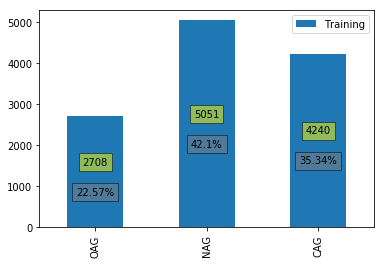

In [9]:
# plot the training data
df = DataFrame.from_dict(Counter([instance[2] for instance in training]), orient='index')
df.rename({0: "Training"}, axis='columns', inplace=True)
plot_data(df)

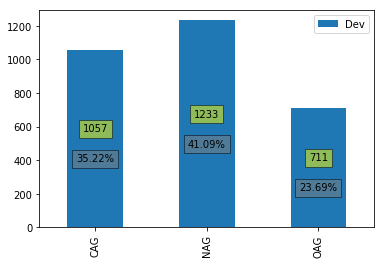

In [10]:
# plot the dev data
df = DataFrame.from_dict(Counter([instance[2] for instance in dev]), orient='index')
df.rename({0: "Dev"}, axis='columns', inplace=True)
plot_data(df)

## Step 2: Calculate the features

### 2.1 Features based on word embeddings

The main purpose of this method was to explore to what extent word embeddings can be used as features for traditional machine learning methods. For the experiments in the paper, I used the pretrained GloVe vectors from https://nlp.stanford.edu/projects/glove/

The experiments were run using <a href="http://nlp.stanford.edu/data/glove.840B.300d.zip">glove.840B.300d.zip</a> (vectors generated using 840B tokens from Common Crawl, 2.2M vocabulary size, cased, 300d vectors)

In [11]:
# path to the uncompressed GloVe vector
path_to_glove="/home/dinel/Projects/2018-aggression/glove/glove.840B.300d.txt"

In [12]:
def loadGloveModel(gloveFile):
    '''
    Loads the embeddings into a dictionary. This will consume lots of memory.
    Returns the dictionary where the keys are the words and the values the embeddings
    '''
    
    print("Loading Glove Model")
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        try:
            embedding = np.array([float(val) for val in splitLine[1:]])            
            model[word] = embedding
        except:
            if debug: print("Problem:", line)
    print("Done.",len(model)," words loaded!")
    return model

In [13]:
# load the embeddings
embeddings = loadGloveModel(path_to_glove)

Loading Glove Model
Done. 2195884  words loaded!


In [14]:
# we can check the vector corresponding to a word
print(embeddings["hate"])

[-6.1052e-01  1.1656e-01 -5.0648e-01 -3.2216e-01 -9.9742e-02  1.0182e-01
  3.1042e-01 -1.8155e-01  3.1774e-01  2.1537e+00 -8.1129e-02 -3.8734e-01
  6.8008e-02 -5.8029e-03 -5.3814e-01 -9.8787e-02 -8.4160e-02  3.1755e-02
 -2.9811e-01  5.0496e-01  4.1719e-01  1.1462e-01  2.5330e-01 -1.6668e-01
  2.6645e-02  4.5709e-02 -5.9685e-01 -3.9645e-01  4.3089e-01  1.3014e-01
 -4.0591e-02  6.6024e-01 -5.3007e-01 -8.1629e-02  3.3484e-01  1.6258e-01
  3.9029e-02  7.2786e-02 -1.8635e-01  3.8104e-01 -5.0557e-01 -3.0910e-02
 -3.2578e-01  3.8818e-01  1.4605e-01  3.8982e-02 -1.4992e-01  6.0316e-01
 -3.0801e-02  1.3456e-01 -6.2982e-01  5.8746e-02  1.5878e-02 -7.8831e-02
  1.4754e-01  5.2191e-02 -4.3654e-01 -1.6707e-01 -1.5184e-02 -1.6073e-01
 -2.1243e-02  8.3719e-02 -6.5062e-01 -7.9566e-02 -4.5479e-02 -1.0070e-01
 -1.4044e-01 -4.1403e-02  1.2033e-01  2.6015e-03  1.0318e-02  1.2444e-01
  3.0785e-01 -2.4270e-01  4.9056e-02  2.1891e-01  1.5346e-01  1.6682e-01
  5.0732e-01  5.9128e-01 -3.0452e-01 -5.8077e-02  1

The features corresponding to a text are calculated by averaging the vectors corresponding to the tokens contained it the text. The function below can be used to find out which tokens are not present in the embeddings. The input of the function is a list which contains all the instances. The text is in the second position of an instance. The tokenizer from NLTK is used. 

In [15]:
def calculate_vector_repr(data):
    '''
    Calculates the vector representation of the text. The input of the function 
    is a list which contains the input (training or testing). The function modifies
    this data by adding the representation at the end of each instance.
    '''
    
    if debug: not_found = open("not-found.txt", "w")
    for instance in data:
        text = instance[1]

        sentVector = np.zeros(300)
        counter = 0

        for word in word_tokenize(text):        
            try:
                sentVector += embeddings[word.lower()]
                counter += 1
            except:
                if debug: not_found.write(word + "\n")
                    
        if counter: 
            sentVector = sentVector / counter
        instance.append(sentVector)
        
    if debug: not_found.close()

If ``debug=True`` calling ``calculate_vector_repr`` creates/appends to a file called ``not-found.txt`` all the words that are not present in the embeddings. This is very useful for measuring the coverage of the word embeddings. In the case of this task, most of the non found words are either poorly tokenised words or words they are not English.

In [16]:
data = [["dummy", "this is a test"]]
calculate_vector_repr(data)
data

[['dummy',
  'this is a test',
  array([-1.69022500e-02,  2.87252250e-01,  1.86550750e-02,  1.34868000e-01,
          4.24300000e-02, -2.67570750e-01,  2.58480000e-02, -2.83737750e-01,
          5.71710000e-02,  2.15382500e+00, -1.57307175e-01, -5.59105000e-02,
         -2.40000000e-03,  4.53894500e-02, -9.60605000e-02, -1.85047625e-01,
          1.54570000e-02,  1.65845000e+00, -1.73122500e-01, -3.72495000e-02,
         -2.85275000e-02, -2.71057750e-01, -4.75250000e-02,  1.30351075e-01,
          6.37230000e-02,  2.03934500e-01,  3.63950000e-03, -1.35885500e-01,
          4.68250000e-03, -1.42760000e-02, -2.46225000e-04,  8.99967500e-02,
          3.52918750e-01, -1.09063000e-01,  4.67625000e-02,  4.68908400e-02,
          6.66356250e-02, -6.19975000e-02, -1.38557592e-01, -3.94212250e-01,
          2.24767500e-01,  1.93722500e-01,  1.34370750e-01, -9.73465000e-02,
          5.74125000e-02,  4.60950000e-03, -2.31309000e-01,  4.35100000e-02,
         -1.65817500e-01,  8.05360750e-02, -1

## 2.2 Extract sentiment features

The sentiment features are determined using <a href="http://sentistrength.wlv.ac.uk/" target="_blank">SentiStrength</a> which is able to assign each text a positive and a negative score. In order to facilitate processing, the input files were split into individual files, each containing only one text. The name of each file matched the ID of the text. The following function was used:

```python
def splitData(file_name, train_data = True):
    with open(file_name, encoding = 'utf8') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if train_data:
                id_ex, text, label = tuple(row)
            else:
                id_ex, text = tuple(row)
            
            f = open("split-test/" + id_ex, "w")
            f.write(text)
            f.close()
            
```

A shell script was run to generate the files containing the scores

```sh
for f in `find $1 -type f`
do
    cat $f | java -jar SentiStrengthCom.jar sentidata ./SentStrength_Data/ stdin > $f.senti
done

```

After this each file contained two numbers separated by a tab which represented the positive and negative scores.

In [17]:
path_to_sentiment_feats = "senti_feats/"

In [18]:
def getSentiFeatures(instance, path):
    '''
    Read the sentiment features corresponding to an instance. 
    Returns a list which contains two elements [positive score, negative score]
    '''
    f = open(path + instance[0] + ".senti")
    line = f.readline()
    f.close()
    return [int(x) for x in line.strip().split()]

### 2.3 Calculate the features based on emojis

The assumption is that some emoticons are more likely to indicate a type of aggression or the lack of aggression than others. The emoticons are converted to their corresponding strings description using <a href="https://pypi.org/project/emoji/" target="_blank">emoji</a> library.

In [19]:
def getEmojis(text):
    """
    Identifies all the emoji in the text using emoji library
    """
    return re.findall("(:[0-9a-zA-Z_]+:)", emoji.demojize(text))

The score of each emoji is calculating using TF*IDF with respect to each class. The implementation used in the official submission considered there are 4 classes instead of 3. This was done in order to avoid having a large number of emojis with score 0, which in turn proved to have a negative influence on the evaluation on the dev data. 

In [20]:
def getEmojiScores(data):
    emos_dist = {'NAG':[], 'CAG':[], 'OAG':[]}
    emo_tfidf = {'NAG':[], 'CAG':[], 'OAG':[]}
    
    for instance in data:
        emos = getEmojis(instance[1])
        for emo in emos:
            emos_dist[instance[2]].append(emo)        
    
    for key,value in emos_dist.items():
        N = len(value)
        for emo,f in nltk.FreqDist(value).most_common(50):
            tf = f/N
            idf = (emo in emos_dist['NAG']) + (emo in emos_dist['CAG']) + (emo in emos_dist['OAG'])
            emo_tfidf[key].append((tf * math.log(4/idf), emo))
        
    return {label : {v:k for k, v in emo_tfidf[label]} for label in labels}

We can see which emojis are ranked in top 10 for each class.

In [21]:
from operator import itemgetter

emoji_scores = getEmojiScores(training)
for label in labels:
    print("\nLabel:", label)
    for em in sorted(emoji_scores[label].items(), key=itemgetter(1), reverse=True)[:10]:
        print(emoji.emojize(em[0]), em[0], em[1])


Label: NAG
♥ :heart_suit: 0.10836526343965343
❌ :cross_mark: 0.07126724532517748
💢 :anger_symbol: 0.048813181729573614
😂 :face_with_tears_of_joy: 0.0362641485696259
😯 :hushed_face: 0.018549009057237973
🌟 :glowing_star: 0.017572745422646502
😽 :kissing_cat_face: 0.015620218153463556
🏨 :hotel: 0.013667690884280612
🏯 :Japanese_castle: 0.013667690884280612
⭐ :white_medium_star: 0.012691427249689139

Label: CAG
😂 :face_with_tears_of_joy: 0.14426913454799128
😀 :grinning_face: 0.017123932884034573
😈 :smiling_face_with_horns: 0.009283221168213552
👏 :clapping_hands: 0.009283221168213552
😝 :squinting_face_with_tongue: 0.008251752149523157
🌹 :rose: 0.008251752149523157
👌 :OK_hand: 0.008251752149523157
😜 :winking_face_with_tongue: 0.007705769797815558
📢 :loudspeaker: 0.006188814112142368
🇺🇸 :United_States: 0.006188814112142368

Label: OAG
😂 :face_with_tears_of_joy: 0.108787338322102
🐣 :hatching_chick: 0.062130839714056724
❌ :cross_mark: 0.05436448474979963
😡 :pouting_face: 0.026592460478736046
🃏 :

For each new text we calculate three features, each corresponding to one of the classes to be predicted.
The values of the features are the sum of the emoticons scores appearing in the text for the corresponding
class. The values of these three features are normalised by the number of emoticons in the text.

In [22]:
def getEmoFeatures(text, scores):
    '''
    Returns the features corresponding to the emoji scores
    '''
    emos_features = {'NAG':0, 'CAG':0, 'OAG':0}
    emos = getEmojis(text)
    for emo in emos:
        for label in labels:
            emos_features[label] += scores[label].get(emo, 0)
            
    for label in labels:
        if len(emos): emos_features[label]/= len(emos)
        
    return emos_features

The examples below show the features on a few examples.

In [23]:
print(training[289])

['facebook_corpus_msr_429182', 'So humble you are Mukesh Ambani.. your  pieces about Entrepreneurs  should inspire a generation.. 🙏👍👌', 'NAG']


In [24]:
print(getEmoFeatures(training[289][1], emoji_scores))

{'NAG': 0.007278423690762763, 'CAG': 0.0051764745417459505, 'OAG': 0.0018802749833449726}


In [25]:
print(training[222])

['facebook_corpus_msr_1689985', 'Stupid survey 👎👎👎', 'OAG']


In [26]:
print(getEmoFeatures(training[222][1], emoji_scores))

{'NAG': 0.0, 'CAG': 0.0, 'OAG': 0.005640824950034919}


## Train the algorithms

As stated above, the purpose of this method was to investigate whether we can use word embeddings (together with some other features) as features for traditional machine learning algorithms. The data for the ML algorithms is prepared by the ``extract_XY`` function. The implementation assumes that the ``emoji_scores`` and ``path_to_sentiment_feats`` variables are correctly initialised in the global scope. 

In [27]:
def extract_XY(data, with_sentiment = 0, with_emojis = 0):
    '''
    Function which prepares the vectors for the machine learning algorithms
    The parameters with_sentiment and with_emojis control whether those
    features will be included
    Returns X and Y
    '''
    X = []
    Y = []
    for instance in data:
        features = list(instance[3])
        if with_emojis:
            features.extend(list(getEmoFeatures(instance[1], emoji_scores).values()))
        if with_sentiment:
            features.extend(getSentiFeatures(instance, path_to_sentiment_feats))
            
        X.append(features)
        Y.append(instance[2])
        
    return X, Y

The following two functions return the model produced by the machine learning algorithms from the training data provided as parameters. The two ML algorithms tried are <a href="http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html" target="_blank">Support Vector Machine</a> and <a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html" target="_blank">Random Forest</a>. Each function takes parameters which can tune the performance of the learning algorithm. The values used in the experiments below are the best values determined through a grid search. 

In [28]:
def trainSVM(X_train, y_train, c, gamma):
    print("Learning ...", end="")
    model = SVC(random_state=57, kernel='rbf', C=c, gamma=gamma)
    model.fit(X_train, y_train)
    print("done!")
    
    return model

In [29]:
def trainRandomForest(X_train, y_train, n_estimators):
    print("Learning ...", end="")
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=10) 
    model.fit(X_train, y_train)
    print("done!")
    
    return model

Before we can start experimenting with the ML algorithms we need to calculate the vector representation for the texts. This will modify the ``training`` and ``dev`` variables. The main reason for implementing the method this way is because deriving the vector representation is time consuming and it shouldn't be done in the ``extractXY`` function.

In [30]:
print("Calculating representation ... ", end="")
calculate_vector_repr(training)
calculate_vector_repr(dev)
print("done!")

Calculating representation ... done!


### Use only word embeddings (not reported in the paper)

In [31]:
print("Calculating features ...", end="")
X_train, y_train = extract_XY(training)
X_dev, y_dev = extract_XY(dev)
print("done!")

Calculating features ...done!


#### SVM, c=2, gamma=0.5

In [32]:
c = 2
gamma = 0.5
model = trainSVM(X_train, y_train, c, gamma)
predicted = model.predict(X_dev)
print(f"SVM with c={c} and gamma={gamma}")
print("accuracy=", np.mean(predicted == y_dev))
print("weighted f-score", f1_score(y_dev, predicted, average='weighted'))
print("Confusion matrix\n", confusion_matrix(y_dev, predicted))

Learning ...done!
SVM with c=2 and gamma=0.5
accuracy= 0.5784738420526491
weighted f-score 0.574230558765779
Confusion matrix
 [[587 324 146]
 [304 863  66]
 [283 142 286]]


#### Random Forest, n_estimators=180

In [33]:
n_estimators = 180
model = trainRandomForest(X_train, y_train, n_estimators)
predicted = model.predict(X_dev)
print(f"Random forest with n_estimators={n_estimators}")
print("accuracy=", np.mean(predicted == y_dev))
print("weighted f-score", f1_score(y_dev, predicted, average='weighted'))
print("Confusion matrix\n", confusion_matrix(y_dev, predicted))

Learning ...done!
Random forest with n_estimators=180
accuracy= 0.5404865044985006
weighted f-score 0.5132813625882178
Confusion matrix
 [[581 425  51]
 [282 917  34]
 [408 179 124]]


### Use word embeddings and emoji scores

In [34]:
print("Calculating features ...", end="")
X_train, y_train = extract_XY(training, with_emojis = True)
X_dev, y_dev = extract_XY(dev, with_emojis = True)
print("done!")

Calculating features ...done!


#### SVM, c=2, gamma=0.5

In [35]:
c = 2
gamma = 0.5
model = trainSVM(X_train, y_train, c, gamma)
predicted = model.predict(X_dev)
print(f"SVM with c={c} and gamma={gamma}")
print("accuracy=", np.mean(predicted == y_dev))
print("weighted f-score", f1_score(y_dev, predicted, average='weighted'))
print("Confusion matrix\n", confusion_matrix(y_dev, predicted))

Learning ...done!
SVM with c=2 and gamma=0.5
accuracy= 0.5768077307564146
weighted f-score 0.5723505370388843
Confusion matrix
 [[585 328 144]
 [302 863  68]
 [286 142 283]]


#### Random Forest, n_estimators=180

In [36]:
n_estimators = 180
model = trainRandomForest(X_train, y_train, n_estimators)
predicted = model.predict(X_dev)
print(f"Random forest with n_estimators={n_estimators}")
print("accuracy=", np.mean(predicted == y_dev))
print("weighted f-score", f1_score(y_dev, predicted, average='weighted'))
print("Confusion matrix\n", confusion_matrix(y_dev, predicted))

Learning ...done!
Random forest with n_estimators=180
accuracy= 0.5341552815728091
weighted f-score 0.5079277755736931
Confusion matrix
 [[560 434  63]
 [279 916  38]
 [400 184 127]]


### Use word embeddings, emoji scores and sentiment scores

In [37]:
print("Calculating features ...", end="")
X_train, y_train = extract_XY(training, with_emojis = True, with_sentiment = True)
X_dev, y_dev = extract_XY(dev, with_emojis = True, with_sentiment = True)
print("done!")

Calculating features ...done!


#### SVM, c=5, gamma=0.5 *(the best performing setting on unseen Twitter testing data)*

In [38]:
c = 5
gamma = 0.5
model = trainSVM(X_train, y_train, c, gamma)
predicted = model.predict(X_dev)
print(f"SVM with c={c} and gamma={gamma}")
print("accuracy=", np.mean(predicted == y_dev))
print("weighted f-score", f1_score(y_dev, predicted, average='weighted'))
print("Confusion matrix\n", confusion_matrix(y_dev, predicted))

Learning ...done!
SVM with c=5 and gamma=0.5
accuracy= 0.5591469510163279
weighted f-score 0.5545043639597993
Confusion matrix
 [[533 352 172]
 [302 859  72]
 [272 153 286]]


#### Random Forest, n_estimators=160 *(the best performing setting on unseen Facebook testing data)*

In [39]:
n_estimators = 160
model = trainRandomForest(X_train, y_train, n_estimators)
predicted = model.predict(X_dev)
print(f"Random forest with n_estimators={n_estimators}")
print("accuracy=", np.mean(predicted == y_dev))
print("weighted f-score", f1_score(y_dev, predicted, average='weighted'))
print("Confusion matrix\n", confusion_matrix(y_dev, predicted))

Learning ...done!
Random forest with n_estimators=160
accuracy= 0.5441519493502166
weighted f-score 0.5214229496782077
Confusion matrix
 [[568 431  58]
 [283 919  31]
 [405 160 146]]
